In [92]:
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import torch
import torch.nn.functional as F
from torch.autograd import Variable

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('MergedData.csv')

In [5]:
df = df.iloc[:,1:]

In [6]:
df = df.iloc[:,1:]

In [7]:
df.head()

,Achievement,Independence,Recognition,Relationships,Support,Working Conditions
0,6.50,6.835,6.500,5.00,4.33,6.33
1,5.33,6.000,5.670,6.33,4.67,6.00
2,5.33,5.330,5.165,5.00,4.00,5.08
3,6.00,5.670,5.330,5.67,5.00,6.17
4,5.33,5.670,4.670,4.00,5.33,5.50


In [8]:
dfNet = pd.read_csv('adjMat.csv')

In [9]:
dfNet.set_index(dfNet.iloc[:,0],inplace = True)

In [10]:
dfNet.set_index(dfNet.iloc[:,0],inplace = True)

In [10]:
dfNet = dfNet.iloc[:,1:]

In [11]:
dfNet.head()

,11-1011,11-1021,11-2011,11-2021,11-2022,11-2031,11-3011,11-3021,11-3031,11-3051,...,53-7061,53-7062,53-7063,53-7064,53-7071,53-7072,53-7073,53-7081,53-7111,53-7121
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
11-1011,0.000000,0.503597,0.656489,0.705882,0.640288,0.686567,0.618705,0.598540,0.633094,0.312500,...,0.092308,0.046154,0.104712,0.198895,0.107527,0.112299,0.119565,0.071795,0.085561,0.111702
11-1021,0.503597,0.000000,0.492308,0.503597,0.496350,0.549618,0.590551,0.507692,0.545455,0.416667,...,0.158537,0.138365,0.125749,0.204969,0.122699,0.170886,0.150943,0.155280,0.118012,0.177215
11-2011,0.656489,0.492308,0.000000,0.722222,0.601504,0.674603,0.590909,0.511111,0.630769,0.226415,...,0.093923,0.080000,0.082873,0.160920,0.067039,0.084270,0.091429,0.077778,0.080460,0.071823
11-2021,0.705882,0.503597,0.722222,0.000000,0.676471,0.779528,0.666667,0.598540,0.759690,0.312500,...,0.097938,0.085106,0.098958,0.166667,0.084211,0.089005,0.095745,0.077320,0.079787,0.100000
11-2022,0.640288,0.496350,0.601504,0.676471,0.000000,0.681818,0.625000,0.546763,0.689394,0.295597,...,0.123656,0.117318,0.125000,0.189944,0.109890,0.127072,0.128492,0.114130,0.117978,0.132597


## Binary weights

In [12]:
dfBin = dfNet > 0.3

In [14]:
edges1 = []
edges2 = []
edges = []

for i in range(df.shape[0]):
    for j in range(i+1,df.shape[0]):
        if dfBin.iloc[i,j]:
            edges.extend([[i,j],[j,i]])
            
            edges1.extend([i,j])
            edges2.extend([i,j])
            

In [15]:
edge_index = torch.tensor([edges1,edges2], dtype=torch.long)

In [16]:
(df.shape[0]*(df.shape[0] - 1))/2

270480.0

In [17]:
edge_index.shape

torch.Size([2, 259000])

## Weighted

In [34]:
from itertools import combinations_with_replacement,combinations

In [35]:
list(combinations_with_replacement(range(3),2))

[(0, 0), (0, 1), (0, 2), (1, 1), (1, 2), (2, 2)]

In [ ]:
edges = 

In [164]:
x = torch.tensor(df.values, dtype=torch.float)

In [165]:
y = torch.tensor(df['Achievement'].values, dtype=torch.float)
# Try making target the work value itself

In [166]:
df.Achievement

0      6.50
1      5.33
2      5.33
3      6.00
4      5.33
       ... 
731    2.33
732    2.33
733    2.00
734    2.00
735    2.67
Name: Achievement, Length: 736, dtype: float64

## Make test/train split

In [167]:
prop = int(y.shape[0]*0.9)
prop_bar = y.shape[0] - prop

In [168]:
train_mask = torch.cat((torch.ones(prop),torch.zeros(prop_bar) ))

In [169]:
train_mask = train_mask.long()

In [170]:
test_mask = torch.cat((torch.zeros(prop),torch.ones(prop_bar) ))

In [171]:
test_mask = test_mask.long()

In [172]:
edge_index.t().contiguous().T

tensor([[  0,   1,   0,  ..., 735, 734, 735],
        [  0,   1,   0,  ..., 735, 734, 735]])

## Make data object

In [173]:
data = Data(x=x, y=y, edge_index=edge_index.t().contiguous().T,train_mask = train_mask, test_mask = test_mask)

In [174]:
edge_index=edge_index.t().contiguous()

In [175]:
data['x'].shape

torch.Size([736, 6])

## Make a network

In [394]:
class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(-1, 2)
        self.conv2 = GCNConv(2, 1) # Try to predict one single work value
        
    def forward(self,data):
        x, edge_index = data.x, data.edge_index
        
        x = self.conv1(x, edge_index)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x,edge_index)

        return x

In [395]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN().to(device)

In [396]:
data = data.to(device)

In [397]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

In [398]:
model.train()

GCN(
  (conv1): GCNConv(-1, 2)
  (conv2): GCNConv(2, 1)
)

In [399]:
for epoch in range(200):
    optimizer.zero_grad()
    out = model(data)
    #loss = F.mse_loss(Variable(data.x[data.train_mask,0],requires_grad = True), data.y[data.train_mask])
    loss = F.mse_loss(Variable(data.x[:,1],requires_grad = True), data.y)
    loss.backward()
    optimizer.step()

In [400]:
model.eval()

GCN(
  (conv1): GCNConv(-1, 2)
  (conv2): GCNConv(2, 1)
)

In [401]:
pred = model(data)

In [402]:
pred.shape

torch.Size([736, 1])

In [403]:
loss = F.mse_loss(pred[:,0],data.y)

In [415]:
loss.abs().item(),np.sqrt(loss.abs().item())

(23.5156307220459, 4.8492917753055345)

In [405]:
type(pred.detach().numpy())

numpy.ndarray

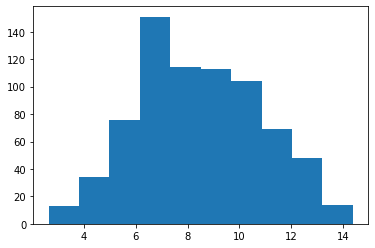

In [406]:
_ = plt.hist(pred.detach().numpy())

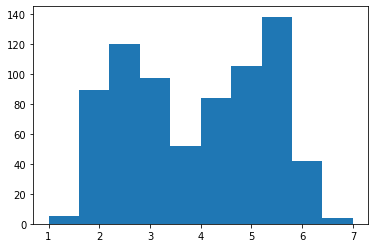

In [407]:
_ = plt.hist(data.y.detach().numpy())

Text(0, 0.5, 'True')

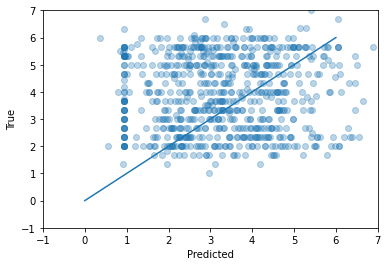

In [445]:
plt.scatter(pred.detach().numpy(),data.y.detach().numpy(),alpha = 0.3)

plt.xlim(-1,7)
plt.ylim(-1,7)

plt.plot([0,6],[0,6])

plt.xlabel('Predicted')
plt.ylabel('True')

## Set up training/testing

In [492]:
x = torch.tensor(df.values, dtype=torch.float)

In [ ]:
data = Data(x=x, y=y, edge_index=edge_index.t().contiguous().T,train_mask = train_mask, test_mask = test_mask)

In [561]:
class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(-1, 4,add_self_loops = False)
        self.conv2 = GCNConv(-1, 4,add_self_loops = False)
        self.conv3 = GCNConv(4, 1,add_self_loops = False) # Try to predict one single work value
        
    def forward(self,data):
        x, edge_index = data.x, data.edge_index
        
        x = self.conv1(x, edge_index)
        #x = F.dropout(x, training=self.training)
        x = self.conv2(x,edge_index)
        #x = F.dropout(x, training=self.training)
        x = self.conv3(x,edge_index)

        return x

In [562]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN().to(device)

In [563]:
data = data.to(device)

In [564]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

In [565]:
model.train()

GCN(
  (conv1): GCNConv(-1, 4)
  (conv2): GCNConv(-1, 4)
  (conv3): GCNConv(4, 1)
)

In [566]:
for epoch in range(200):
    optimizer.zero_grad()
    out = model(data)
    #loss = F.mse_loss(Variable(data.x[data.train_mask,0],requires_grad = True), data.y[data.train_mask])
    #loss = F.mse_loss(Variable(data.x[:,1],requires_grad = True), data.y)
    loss = F.mse_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print('LOSS = {:.4f}'.format(loss.item()))

/Users/alexisrutherford/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Using a target size (torch.Size([736])) that is different to the input size (torch.Size([736, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  


LOSS = 52.4844
LOSS = 8.1272
LOSS = 2.9046
LOSS = 0.2399
LOSS = 0.3423
LOSS = 0.2872
LOSS = 0.1584
LOSS = 0.1269
LOSS = 0.1273
LOSS = 0.1277
LOSS = 0.1269
LOSS = 0.1262
LOSS = 0.1258
LOSS = 0.1256
LOSS = 0.1255
LOSS = 0.1253
LOSS = 0.1252
LOSS = 0.1251
LOSS = 0.1250
LOSS = 0.1249


In [567]:
pred = model(data)

In [568]:
#loss = F.mse_loss(pred[:,0],data.y)
loss = F.mse_loss(pred[data.test_mask],data.y[data.test_mask])

/Users/alexisrutherford/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Using a target size (torch.Size([736])) that is different to the input size (torch.Size([736, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  


In [569]:
loss.abs().item(),np.sqrt(loss.abs().item())

(0.8461951613426208, 0.9198886679064053)

Text(0, 0.5, 'True')

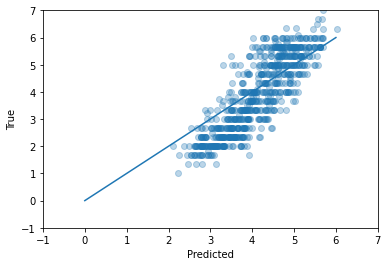

In [570]:
plt.scatter(pred.detach().numpy(),data.y.detach().numpy(),alpha = 0.3)

plt.xlim(-1,7)
plt.ylim(-1,7)

plt.plot([0,6],[0,6])

plt.xlabel('Predicted')
plt.ylabel('True')

In [571]:
!pwd

/Users/alexisrutherford/Desktop/foh_vae
